# Extraction of Down States from Neocortex recordings

Restarting from LFPwake0 and LFPwakeremoved.

LFPwakeremoved will be used to determined signal variance for threshold adjustement. 

LFPwake0 will be used for time determination. 

## Load LFP and packages

In [273]:
cd "//10.69.168.1/crnldata/waking/audrey_hay/L1imaging/AnalysedMarch2023/"

\\10.69.168.1\crnldata\waking\audrey_hay\L1imaging\AnalysedMarch2023


In [405]:
from scipy import signal
from scipy import stats
from scipy.signal import find_peaks, peak_widths, hilbert
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button, Cursor
from scipy import fftpack
import pandas as pd
from pathlib import Path
import os
%matplotlib widget

folder_base = Path('Gaelle/Baseline_recording/GreenDotsOK/session2/OpenEphys') 

filename = folder_base / f'LFPwake0.npy'
filename3 = folder_base / f'LFPwakeremoved.npy'
filename2 = folder_base / f'RawDataChannelExtractedDS.npy'
EMGbooleaninput = folder_base / f'EMGframeBoolean.pkl'
Channels = 'LFPChannels_perMice.xlsx' 

EMGboolean = pd.read_pickle(EMGbooleaninput)
LFPwakeremoved = np.load(filename3, mmap_mode= 'r')
All = np.load(filename2, mmap_mode= 'r')

def readfile(file):
  with open(file, encoding="utf-8") as file:
    list = []
    for row in file:
      temp = row.split()
      list.append(temp[:])
    return list

mice = os.path.basename(os.path.dirname(os.path.dirname(folder_base)))
allchannels = pd.read_excel(Channels)
PFCch1=int(allchannels[mice][0].split(',')[0])
PFCch2=int(allchannels[mice][0].split(',')[1])
S1ch1=int(allchannels[mice][1].split(',')[0])
S1ch2=int(allchannels[mice][1].split(',')[1])

PFC  =  All[:, PFCch1]-All[:, PFCch2] 
PFCwakeremoved = LFPwakeremoved[:,PFCch1]-LFPwakeremoved[:,PFCch2] 

S1  =  All[:, S1ch1]-All[:, S1ch2] 
S1wakeremoved = LFPwakeremoved[:,S1ch1]-LFPwakeremoved[:,S1ch2] 

## Continuous Wavelet Transform and projection calculation

First on signal with no wake time to determine sd of signal

In [406]:
# Filter parameter :
f_lowcut = 0.5
f_hicut = 3.5
N = 2
fs = 1000
nyq = 0.5 * fs
Wn = [f_lowcut/nyq,f_hicut/nyq]  # Nyquist frequency fraction

# Filter creation :
b, a = signal.butter(N, Wn, 'band')

filt_S1 = signal.filtfilt(b, a, S1)
filt_S1wakeremoved = signal.filtfilt(b, a, S1wakeremoved)

filt_PFC = signal.filtfilt(b, a, PFC)
filt_PFCwakeremoved = signal.filtfilt(b, a, PFCwakeremoved)


In [407]:
# Conservative boolean filtering of CA1 filtered signal
BooleanCons = EMGboolean['BooleanConservative']
fS1wake0C = filt_S1.copy()
fS1wake0C[BooleanCons] = 0
S1wake0C = S1.copy()
S1wake0C[BooleanCons] = 0
# Liberal boolean filtering of CA1 filtered signal
BooleanLib = EMGboolean['BooleanLiberal']
fS1wake0L = filt_S1.copy()
fS1wake0L[BooleanLib] = 0
S1wake0L = S1.copy()
S1wake0L[BooleanLib] = 0

normalized_filt_S1wakeremoved = (fS1wake0L - np.mean(fS1wake0L)) / np.std(fS1wake0L)

peaks, properties = find_peaks(normalized_filt_S1wakeremoved, prominence=2, height=3)
results_width = peak_widths(normalized_filt_S1wakeremoved, peaks, rel_height=0.5)

peaks2 = peaks.reshape(len(peaks),1)
npresults_width = np.array(results_width).reshape(4,-1)
DownStates_prop = np.append(peaks2, results_width).reshape(5,len(peaks2)).round()

DownStates_peak = peaks
DownStates_start = DownStates_prop[3,:].astype(int)
DownStates_end = DownStates_prop[4,:].astype(int)

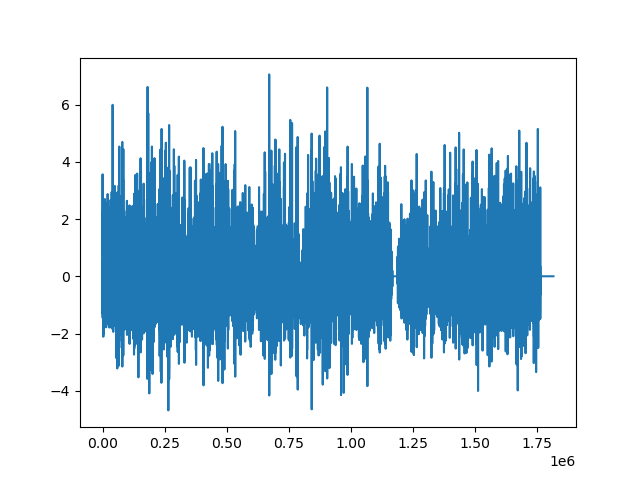

In [408]:
plt.close()
plt.plot(normalized_filt_S1wakeremoved)
plt.show()

In [409]:
print(max(normalized_filt_S1wakeremoved))
print(min(normalized_filt_S1wakeremoved))
print(np.std(normalized_filt_S1wakeremoved))

7.055480455273049
-4.6863480625345995
0.9999999999999997


In [410]:
nb_DownStates = np.arange(0,len(peaks),1)
data = np.zeros((len(peaks),4))

for tt in nb_DownStates:
    DownStates_prop_start = int(DownStates_prop[3,tt])
    DownStates_prop_stop = int(DownStates_prop[4,tt])
    DownStates_prop_MaxP = normalized_filt_S1wakeremoved[DownStates_prop_start:DownStates_prop_stop]
    DownStates_prop_MaxF = normalized_filt_S1wakeremoved[DownStates_prop_start:DownStates_prop_stop]
    data[tt, 0] = max(DownStates_prop_MaxF).round()
    data[tt, 1] = max(DownStates_prop_MaxP).round()
    data[tt, 2] = round(sum(DownStates_prop_MaxF)/len(DownStates_prop_MaxF))
    data[tt, 3] = round(sum(DownStates_prop_MaxP)/len(DownStates_prop_MaxP))

param_DownStates_prop= pd.DataFrame(data, columns = ['Max freq', 'Max int', 'Avg freq', 'Avg int'])
tDownStates_prop = DownStates_prop.transpose()
pd_prop_DownStates_prop = pd.DataFrame(tDownStates_prop, columns = ['peak time', 'Duration', 'peak amp', 'start time', 'end time'])
All_DownStates_prop = pd.concat([pd_prop_DownStates_prop, param_DownStates_prop], axis=1)
len(All_DownStates_prop)

224

### Display

ephys viewer to check DownStates detection

In [411]:
from ephyviewer import mkQApp, MainViewer, TraceViewer
from ephyviewer import AnalogSignalSourceWithScatter
import ephyviewer

app = mkQApp()

sample_rate = 1000.
t_start = 0.

combined = np.stack([S1, filt_S1, normalized_filt_S1wakeremoved/5], axis = 1)

#create 2 familly scatters from theses 2 indexes
scatter_indexes = {0: DownStates_start, 1: DownStates_end}
#and asign them to some channels each
scatter_channels = {0: [0, 1], 1: [0, 1]}
source = AnalogSignalSourceWithScatter(combined, sample_rate, t_start, scatter_indexes, scatter_channels)

#Create the main window that can contain several viewers
win = MainViewer(debug=True, show_auto_scale=True)

#create a viewer for signal with TraceViewer
#connected to the signal source
view1 = TraceViewer(source=source)

#Parameters can be set in script
#view1.params['scale_mode'] = 'same_for_all'
view1.params['display_labels'] = True
#And also parameters for each channel


view1.by_channel_params['ch0', 'color'] = '#ffffff'
view1.by_channel_params['ch1', 'color'] = '#0055ff'
view1.by_channel_params['ch0', 'gain'] = 0.0003
view1.by_channel_params['ch1', 'gain'] = 0.001
view1.by_channel_params['ch0', 'offset'] = 1
view1.by_channel_params['ch1', 'offset'] = -1


#put this viewer in the main window
win.add_view(view1)

#Run
win.show()
app.exec_()

debug True
QT_MODE PyQt5
refresh duration for  0.0 s
